<a href="https://colab.research.google.com/github/Kimjibeom/LSTM/blob/main/LSTM_%EB%AA%A8%EB%8D%B8_%EC%A0%80%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split 
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import os
import json
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from pymongo import MongoClient
from dateutil import parser
from datetime import datetime, timedelta
# import lstm, time #도움을 주는 라이브러리들

In [2]:
conn = MongoClient(#DB 주소)
db = conn.get_database("traffic_Sejong_road")

In [3]:
coll_list = db.list_collection_names()
print(coll_list)

['df_l', 'df_m', 'df_s', 'df_e', 'df_h', 'df_d', 'df_c', 'df_p', 'df_u', 'df_q', 'df_g', 'df_r', 'df_k', 'df_b', 'df_a', 'df_n', 'df_o', 'df_f']


In [4]:
collection_name = db.df_s
cursor = collection_name.find()
list_cur = list(cursor)

In [5]:
data = pd.DataFrame(list_cur)
data=data.drop(['_id','Datetime'],axis=1)

In [6]:
data.astype('float')

,s_1도로총교통량,s_1평균통행속도,s_1점유율,s_2도로총교통량,s_2평균통행속도,s_2점유율,s_3도로총교통량,s_3평균통행속도,s_3점유율,s_4도로총교통량,s_4평균통행속도,s_4점유율,s_5도로총교통량,s_5평균통행속도,s_5점유율,s_6도로총교통량,s_6평균통행속도,s_6점유율,s_7도로총교통량,s_7평균통행속도,s_7점유율,s_8도로총교통량,s_8평균통행속도,s_8점유율,s_9도로총교통량,s_9평균통행속도,s_9점유율,s_10도로총교통량,s_10평균통행속도,s_10점유율,s_11도로총교통량,s_11평균통행속도,s_11점유율,s_12도로총교통량,s_12평균통행속도,s_12점유율,휴일
0,210.0,56.000,2.41625,175.0,55.625,3.00375,189.0,53.500,3.84250,216.0,53.500,3.38125,232.0,59.250,3.14250,220.0,51.625,3.45375,23.0,65.8571,1.528571,14.0,75.2857,1.391429,229.0,56.375,2.76625,259.0,53.375,3.67625,93.0,62.625,2.34625,60.0,63.750,1.62250,1.0
1,250.0,54.000,3.04625,183.0,56.375,2.90500,167.0,59.250,2.20875,136.0,58.375,2.60125,194.0,60.875,2.77500,177.0,48.000,3.55000,28.0,62.5000,1.382500,13.0,60.2857,1.342857,162.0,57.375,2.18750,176.0,55.250,2.98375,114.0,63.000,2.61625,59.0,64.375,1.89250,1.0
2,135.0,54.375,2.33750,104.0,59.750,2.03875,83.0,61.625,1.94750,87.0,56.875,2.41625,86.0,64.625,1.95000,101.0,58.375,2.67500,19.0,64.4286,1.232857,12.0,60.6250,1.480000,74.0,55.625,1.81000,114.0,56.500,2.62250,64.0,64.750,2.01000,48.0,66.750,1.75250,1.0
3,83.0,56.750,1.97125,70.0,61.250,1.99000,66.0,61.375,2.23125,77.0,59.375,2.31750,67.0,64.625,1.86000,74.0,60.250,2.03875,13.0,75.1250,1.221250,8.0,53.6000,1.854000,65.0,60.000,1.77625,69.0,59.500,2.13375,35.0,65.125,1.94625,37.0,71.375,1.60625,1.0
4,91.0,60.375,1.85750,80.0,64.500,1.91125,48.0,60.250,1.96250,61.0,59.500,1.85875,58.0,63.750,1.85125,87.0,57.875,2.05375,16.0,62.2000,1.472000,9.0,72.7143,1.545714,59.0,58.750,1.76250,63.0,60.500,2.19625,32.0,64.375,1.76500,47.0,68.000,1.76625,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23899,NaN,NaN,NaN,NaN,NaN,NaN,613.0,47.625,6.69125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,578.0,49.125,5.45500,NaN,NaN,NaN,NaN,NaN,NaN,402.0,42.875,5.65500,1.0
23900,NaN,NaN,NaN,NaN,NaN,NaN,519.0,49.750,5.68750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,510.0,50.000,4.94875,NaN,NaN,NaN,NaN,NaN,NaN,320.0,43.625,5.22250,1.0
23901,NaN,NaN,NaN,NaN,NaN,NaN,385.0,51.750,4.80750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,402.0,50.375,4.19500,NaN,NaN,NaN,NaN,NaN,NaN,291.0,42.250,5.35250,1.0
23902,NaN,NaN,NaN,NaN,NaN,NaN,273.0,52.000,3.64625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,369.0,51.750,3.56125,NaN,NaN,NaN,NaN,NaN,NaN,218.0,45.875,4.19250,1.0


In [7]:
# Normalization - 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_clos = ['s_1도로총교통량','s_1평균통행속도','s_1점유율',
             's_2도로총교통량','s_2평균통행속도','s_2점유율',
             's_3도로총교통량','s_3평균통행속도','s_3점유율',
             's_4도로총교통량','s_4평균통행속도','s_4점유율',
             's_5도로총교통량','s_5평균통행속도','s_5점유율',
             's_6도로총교통량','s_6평균통행속도','s_6점유율',
             's_7도로총교통량','s_7평균통행속도','s_7점유율',
             's_8도로총교통량','s_8평균통행속도','s_8점유율',
             's_9도로총교통량','s_9평균통행속도','s_9점유율',
             's_10도로총교통량','s_10평균통행속도','s_10점유율',
             's_11도로총교통량','s_11평균통행속도','s_11점유율',
             's_12도로총교통량','s_12평균통행속도','s_12점유율','휴일']
df_scaled = scaler.fit_transform(data[scale_clos])

df_scaled = pd.DataFrame(data=df_scaled,columns=scale_clos)

train = df_scaled[:18000] # 학습 데이터
test = df_scaled[18000:] # 테스트 데이터

In [8]:
# 학습 시킬 데이터 셋 생성 함수
# 5시간 기반으로 데이터 셋 묶기
def make_dataset(data,label,window_size=5):
    feature_list =[] # 학습
    label_list =[] # 답
    for i in range(len(data)-window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list),np.array(label_list)
# 한누리대로 
feature_cols = ['s_1도로총교통량','s_1평균통행속도','s_1점유율',
             's_2도로총교통량','s_2평균통행속도','s_2점유율',
             's_3도로총교통량','s_3평균통행속도','s_3점유율',
             's_4도로총교통량','s_4평균통행속도','s_4점유율',
             's_5도로총교통량','s_5평균통행속도','s_5점유율',
             's_6도로총교통량','s_6평균통행속도','s_6점유율',
             's_7도로총교통량','s_7평균통행속도','s_7점유율',
             's_8도로총교통량','s_8평균통행속도','s_8점유율',
             's_9도로총교통량','s_9평균통행속도','s_9점유율',
             's_10도로총교통량','s_10평균통행속도','s_10점유율',
             's_11도로총교통량','s_11평균통행속도','s_11점유율',
             's_12도로총교통량','s_12평균통행속도','휴일'] # 학습 컬럼
label_cols = ['s_12점유율'] # 답 컬럼

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature,train_label = make_dataset(train_feature,train_label,5)

# train,test set 생성
X_train,X_test,y_train,y_test = \
train_test_split(train_feature,train_label,test_size=0.8,shuffle=False)

test_feature = test[feature_cols]
test_label = test[label_cols]

# test dataset(실제 예측 데이터)
test_feature,test_label = make_dataset(test_feature,test_label,5)

In [13]:
model = models.Sequential()
model.add(
        layers.LSTM(32,            # 노드 개수
        input_shape=(X_train.shape[1],X_train.shape[2]),# input_dim 입력 데이터의 피쳐 개수
        activation='relu', # 모델을 활성화 함수 선형-> 비선형
        return_sequences = True)
        )
model.add(
        layers.LSTM(32,activation='relu')
        )

model.add(
        layers.Dense(24)
        ) # 예측하고자하는 target이 1시간 ~ 24시간뒤 (output)
    
model.summary()
model.compile(loss='mse',optimizer='adam',metrics=['acc'])
callbacks = [ModelCheckpoint(filepath='./chk_point/a.chk', save_freq='epoch')]
history = model.fit(X_train,y_train,epochs=20,batch_size=32
               ,validation_data=(X_test,y_test)
               ,callbacks=callbacks
               ,shuffle = False
      )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 32)             8832      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                792       
Total params: 17,944
Trainable params: 17,944
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
113/113 [==============================] - 4s 17ms/step - loss: 0.0025 - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./chk_point/a.chk/assets
Epoch 2/20
113/113 [==============================] - 2s 14ms/step - loss: 9.0496e-04 - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./chk

In [14]:
# 예측
pred =model.predict(test_feature)

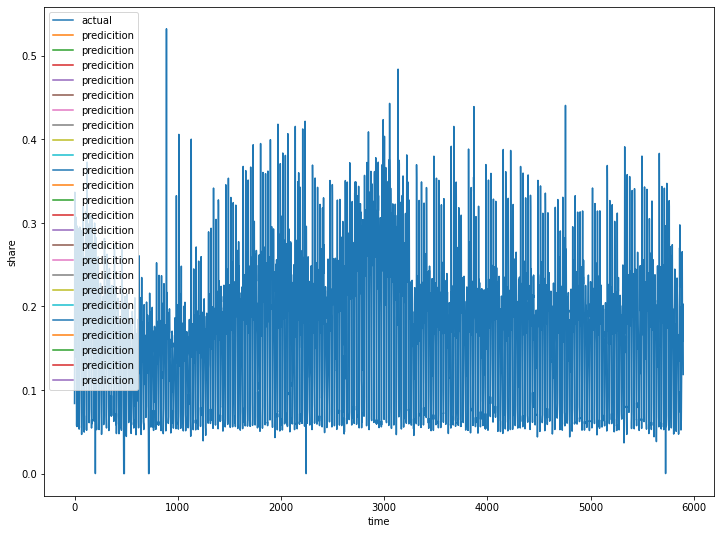

In [15]:
# 시각화
plt.figure(figsize=(12,9))
plt.plot(test_label,label='actual') # 실제
plt.plot(pred,label='predicition') # 예측
plt.xlabel('time')
plt.ylabel('share')
plt.legend()
plt.show()

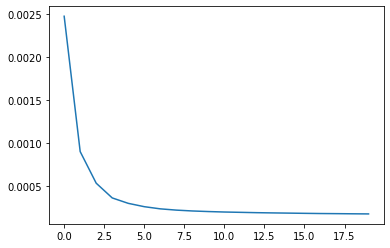

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [17]:
# 모델 저장하기
model.save('s_12.h5')